# Example of MaxFuse usage between RNA and Protein modality.

In this tutorial, we demonstrate the application of MaxFuse integration and matching across weak-linked modalities. Here we showcase an example between RNA and Protein modality. For testing reason, we uses a CITE-seq pbmc data with 228 antibodies from Hao et al. (2021), and we use the Protein and RNA information but __disregard the fact they are multiome data__.

In [4]:
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc
import maxfuse as mf

## Data acquire

Since the example data we are uisng in the tutorial excedes the size limit for github repository files, we have uploaded them onto a server and can be easily donwloaded with the code below. Also this code only need to run **once** for both of the tutorial examples.

In [2]:
import requests, zipfile, io
r = requests.get("http://stat.wharton.upenn.edu/~zongming/maxfuse/data.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("../")

## Data preprocessing

We begin by reading in protein measurements and RNA measurements.

Note that the two modalities in this example have *matching rows* since CITE-Seq measures proteins and RNAs simultaneously.
But we will ignore this fact and treat the two modalities as if they are measured separately.

The file format for MaxFuse to read in is ```adata```. In this tutorial we read in the original RNA counts or Protein counts where each row is a cell and each column is a feature, then turn them into ```adata``` objects.

In [5]:
# read in protein data
protein = pd.read_csv("../data/citeseq_pbmc/pro.csv") # 10k cells (protein)
# convert to AnnData
protein_adata = ad.AnnData(
    protein.to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein.columns

In [6]:
# read in RNA data
rna = mmread("../data/citeseq_pbmc/rna.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('../data/citeseq_pbmc/citeseq_rna_names.csv')['names'].to_numpy()
# convert to AnnData
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

**Optional**: meta data for the cells. In this case we are using them to **evaluate the integration results**, but for actual running, MaxFuse does not require you have this information.

In [4]:
# read in celltyle labels
metadata = pd.read_csv('../data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

Here we are integrating protein and RNA data, and most of the time there are name differences between protein (antibody) and their corresponding gene names. 

These "weak linked" features will be used during initialization (we construct two arrays, `rna_shared` and `protein_shared`, whose columns are matched, and the two arrays can be used to obtain the initial matching). 

To construct the feature correspondence in straight forward way, we prepared a ```.csv``` file containing most of the antibody name (seen in cite-seq or codex etc) and their corresponding gene names:


In [5]:
correspondence = pd.read_csv('../data/protein_gene_conversion.csv')
correspondence.head()

,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG


But of course this files does contain all names including custom names in new assays. If a certain correspondence is not found, either it is missing in the other modality, or you should customly add the name conversion to this ```.csv``` file.

In [6]:
rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
            
rna_protein_correspondence = np.array(rna_protein_correspondence)

In [7]:
# Columns rna_shared and protein_shared are matched.
# One may encounter "Variable names are not unique" warning,
# this is fine and is because one RNA may encode multiple proteins and vice versa.
rna_shared = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].copy()

/Users/bokaizhu/opt/anaconda3/envs/maxfuse_test/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/bokaizhu/opt/anaconda3/envs/maxfuse_test/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
# Make sure no column is static
mask = (
    (rna_shared.X.toarray().std(axis=0) > 1e-5) 
    & (protein_shared.X.std(axis=0) > 1e-5)
)
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()

We apply standard Scanpy preprocessing steps to `rna_shared` and `protein_shared`.
One modification we do is that we normalize the rows of the two arrays to be a common `target_sum`.
If the input data is already pre-processed (normalized etc), we suggest skipping the standardized processing steps below.

In [9]:
# row sum for RNA
rna_counts = rna_shared.X.toarray().sum(axis=1)
# row sum for protein
protein_counts = protein_shared.X.sum(axis=1)
# take median of each and then take mean
target_sum = (np.median(rna_counts.copy()) + np.median(protein_counts.copy())) / 2

In [10]:
# process rna_shared
sc.pp.normalize_total(rna_shared, target_sum=target_sum)
sc.pp.log1p(rna_shared)
sc.pp.scale(rna_shared)
rna_shared = rna_shared.X.copy()

In [11]:
# process protein_shared
sc.pp.normalize_total(protein_shared, target_sum=target_sum)
sc.pp.log1p(protein_shared)
sc.pp.scale(protein_shared)
protein_shared = protein_shared.X.copy()

We again apply standard Scanpy preprocessing steps to **all available RNA measurements and protein measurements** (not just the shared ones) to get two arrays, `rna_active` and `protein_active`, which are used for iterative refinement. Again if the input data is already processed, these steps can be skipped.

In [12]:
# process all RNA features
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata)
# only retain highly variable genes
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sc.pp.scale(rna_adata)

In [13]:
# process all protein features
sc.pp.normalize_total(protein_adata)
sc.pp.log1p(protein_adata)
sc.pp.scale(protein_adata)

In [14]:
# make sure no feature is static
rna_active = rna_adata.X
protein_active = protein_adata.X
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-5]
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-5]

## Fitting MaxFuse

### Step I: preparations

We now have four arrays. `rna_shared` and `protein_shared` are used for finding initial pivots, whereas `rna_active` and `protein_active` are used for iterative refinement. 

The main object for running MaxFuse pipeline is `mf.model.Fusor`, and its constructor takes the above four arrays as input.

If your data have not been clustered and annotated, you can leave `labels1` and `labels2` to be `None`, then MaxFuse will automatically run clustering algorithms to fill them in.

**Optional**: If your data have already been clustered (and you trust your annotation is optimal and should be used to guide the MaxFuse smoothing steps), you could supply them as ```numpy``` arrays to `labels1` and `labels2`.

In [15]:
# call constructor for Fusor object
# which is the main object for running MaxFuse pipeline
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,
    labels2=None
)

To reduce computational complexity, we call `split_into_batches` to fit the batched version of MaxFuse.

Internally, MaxFuse will solve a few linear assignment problems of size $n_1 \times n_2$, where $n_1$ and $n_2$ (with $n_1\leq n_2$ by convention) are the sample sizes of the two modalities (after batching and metacell construction).
`max_outward_size` specifis the maximum value of $n_1$.

`matching_ratio` specifies approximately the ratio of $n_2/n_1$.
The larger it is, the more candidate cells in the second modality MaxFuse will seek for to match each cell/metacell in the first modality.

`metacell_size` specifies the average size of the metacells in the first modality.

In [16]:
fusor.split_into_batches(
    max_outward_size=5000,
    matching_ratio=3,
    metacell_size=2,
    verbose=True
)

The first data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
The second data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
Batch to batch correspondence is:
  ['0<->0'].


The next step is to construct appropriate nearest-neighbor graphs for each modality with all features available.
But before that, we plot the singular values of the two active arrays to determine how many principal components (PCs) to keep when doing graph construction.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

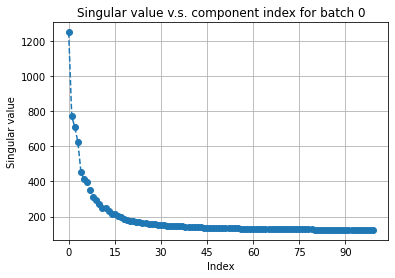

In [17]:
# plot top singular values of avtive_arr1 on a random batch
fusor.plot_singular_values(
    target='active_arr1',
    n_components=None # can also explicitly specify the number of components
)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

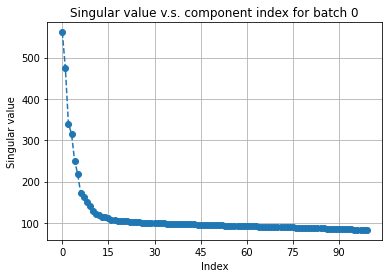

In [18]:
# plot top singular values of avtive_arr2 on a random batch
fusor.plot_singular_values(
    target='active_arr2',
    n_components=None
)

Inspecting the "elbows", we choose the number of PCs to be **30** for both RNA and protein active data.
We then call `construct_graphs` to compute nearest-neighbor graphs as needed.

In [19]:
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=30,
    svd_components2=30,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!


### Step II: finding initial pivots

We then use shared arrays whose columns are matched to find initial pivots.
Before we do so, we plot top singular values of two shared arrays to determine how many PCs to use.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

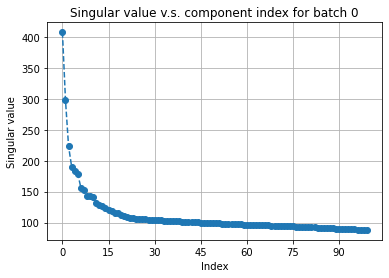

In [20]:
# plot top singular values of shared_arr1 on a random batch
fusor.plot_singular_values(
    target='shared_arr1',
    n_components=None,
)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

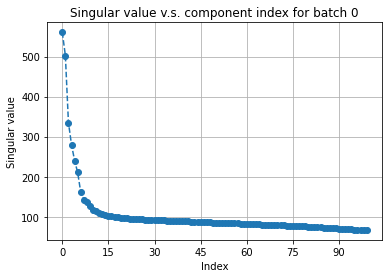

In [21]:
# plot top singular values of shared_arr2 on a random batch
fusor.plot_singular_values(
    target='shared_arr2',
    n_components=None
)

We choose to use **25** PCs for ``rna_shared`` and **20** PCs for ``protein_shared``.

We then call ``find_initial_pivots`` to compute initial set of matched pairs.
In this function, ``wt1`` (resp. ``wt2``) is a number between zero and one that specifies the weight on the smoothing target for the first (resp. second) modality. 
The smaller it is, the greater the strength of fuzzy smoothing.
When the weight is one, then there is no smoothing at all, meaning the original data will be used.

In [22]:
fusor.find_initial_pivots(
    wt1=0.7, wt2=0.7,
    svd_components1=25, svd_components2=20
)

Now at batch 0<->0...
Done!


Now, we have a set of *initial pivots* that store the matched pairs when only the information in the shared arrays is used. The information on initial pivots are stored in the internal field ``fusor._init_matching`` that is invisible to users.

### Step III: finding refined pivots

We now use the information in active arrays to iteratively refine initial pivots. Recall we chose the number of PCs for the active arrays to be **30**.
We plot the top canonical correlations to choose the best number of components in canonical correlation analysis (CCA).

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot: title={'center': 'Canonical correlation v.s. component index for batch 0<->0'}, xlabel='Index', ylabel='Canonical correlation'>)

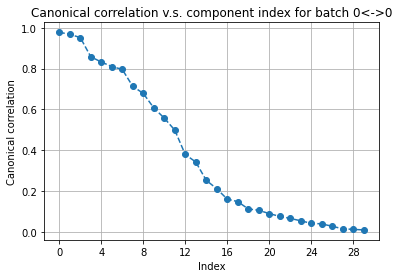

In [23]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=30,
    svd_components2=30,
    cca_components=30
)

From the "elblow" above, we choose retain top **20** canonical scores.

We then call `refine_pivots` to get the refined pivots.
Here, `wt1` and `wt2` admit their usual interpretation of controling the strength of smoothing.
`n_iters` specifies the number of iterations, which we choose to be **3**.
We recommend setting `n_iters` to be *less than 5*, as higher iterations will be slower and may make the algorithm diverge when the signal-to-noise ratio is ultra low.

In [24]:
fusor.refine_pivots(
    wt1=0.7, wt2=0.7,
    svd_components1=30, svd_components2=30,
    cca_components=20,
    n_iters=3,
    randomized_svd=False, 
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Done!


The function `filter_bad_matches` filters away unreliable pivots and is helpful for the propagation step.
`filter_prop` specifies approximately the proportion of pivots to be filtered away.

In [25]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.3)

Begin filtering...
Now at batch 0<->0...
3500/5000 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
6922/10000 cells in arr1 are selected as pivots.
3500/10000 cells in arr2 are selected as pivots.
Done!


We can extract the matched pairs in refined pivots by calling `get_matching` function.
The resulting `pivot_matching` is a nested list.
`pivot_matching[0][i]` and `pivot_matching[1][i]` constitute the matched pair from the first and the second modality;
`pivot_matching[2][i]` is a *quality score* (between zero and one) assigned to this matched pair.

In [26]:
pivot_matching = fusor.get_matching(target='pivot')

We now compute the cell type level accuracy to evaluate the performance. (This step is not required for actual MaxFuse running)

In [27]:
lv1_acc = mf.metrics.get_matching_acc(matching=pivot_matching, 
    labels1=labels_l1, 
    labels2=labels_l1 
)
lv2_acc = mf.metrics.get_matching_acc(matching=pivot_matching, 
    labels1=labels_l2, 
    labels2=labels_l2 
)
print(f'lv1 matching acc: {lv1_acc:.3f},\nlv2 matching acc: {lv2_acc:.3f}.')

lv1 matching acc: 0.946,
lv2 matching acc: 0.846.


We can also compute the confusion matrix to see where the pivot matching goes wrong.

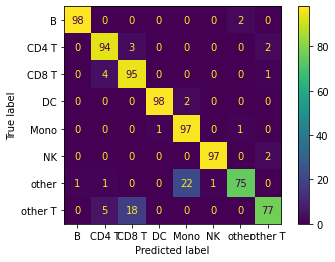

In [28]:
cm = confusion_matrix(labels_l1[pivot_matching[0]], labels_l1[pivot_matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100), 
    display_labels=np.unique(labels_l1)
).plot()

As long as the refined pivots have been obtained, we can get joint embedding of the *full* datasets (active arrays).

In [29]:
rna_cca, protein_cca = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2
)

Since we know the ground truth matching (it is the identity matching as we manually cut CITE-Seq data into halves), we can compute *fraction of samples closer than the true match* (FOSCTTM). The smaller this metric is, the better the joint embeddings.
We refer the readers to our paper for more metrics.

In [30]:
dim_use = 15 # dimensions of the CCA embedding to be used for UMAP etc

mf.metrics.get_foscttm(
    dist=mf.utils.cdist_correlation(rna_cca[:,:dim_use], protein_cca[:,:dim_use]),
    true_matching='identity'
)

0.055344700000000004

We can also plot the UMAP visualizations of the joint embeddings and we can see that: (1) the two datasets mix well; and (2) the cell types are preseved.

Empirically, we find *10-20* dimensions of the joint embeddings best represents the data, similar to choosing PCA components to plot UMAPs in the conventional pipelines.

In [31]:
cca_adata = ad.AnnData(
    np.concatenate((rna_cca[:,:dim_use], protein_cca[:,:dim_use]), axis=0), 
    dtype=np.float32
)
cca_adata.obs['data_type'] = ['rna'] * rna_cca.shape[0] + ['protein'] * protein_cca.shape[0]
cca_adata.obs['cell_type_lv1'] = list(labels_l1) * 2

/Users/bokaizhu/opt/anaconda3/envs/maxfuse_test/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


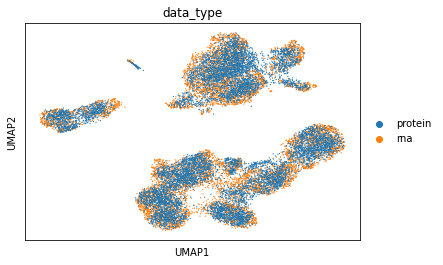

In [32]:
sc.pp.neighbors(cca_adata, n_neighbors=15)
sc.tl.umap(cca_adata)
sc.pl.umap(cca_adata, color='data_type')

/Users/bokaizhu/opt/anaconda3/envs/maxfuse_test/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


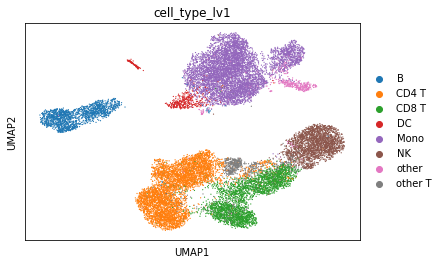

In [33]:
sc.pl.umap(cca_adata, color='cell_type_lv1')

### Step IV: propagation

Refined pivots can only give us a pivot matching that captures a subset of cells. In order to get a *full* matching that involves all cells during input, we need to call `propagate`.

Propagation uses active arrays, so we set the SVD components to be **30**.

In [34]:
fusor.propagate(
    svd_components1=30, 
    svd_components2=30, 
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...
Done!


We call `filter_bad_matches` with `target=propagated` to optionally filter away a few matched pairs from propagation. 
Here, we want a full matching, so we do not do any filtering and set `filter_prop=0`. But in other cases where you believe some proportion of cells from the original input can be removed, you could increase this value.

In [35]:
fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0
)

Begin filtering...
Now at batch 0<->0...
8000/8000 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


We use `get_matching` with `target='full_data'` to extract the full matching.

Because of the batching operation, the resulting matching may contain duplicates. The `order` argument determines how those duplicates are dealt with. 
`order=None` means doing nothing and returning the matching with potential duplicates;
`order=(1, 2)` means returning a matching where each cell in the first modality contains *at least one match* in the second modality;
`order=(2, 1)` means returning a matching where each cell in the second modality contains *at least one match* in the first modality.

In [36]:
full_matching = fusor.get_matching(order=(2, 1), target='full_data')

Since we are doing `order=(2, 1)` here, the matching info is all the cells (10k) in mod 2 (protein) has at least one match cell in the RNA modality. Note that the matched cell in RNA could be duplicated, as protein cells could be matched to the same RNA cell. For a quick check on matching format:

In [37]:
pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])), 
             columns = ['mod1_indx', 'mod2_indx', 'score'])
# columns: cell idx in mod1, cell idx in mod2, and matching scores

,mod1_indx,mod2_indx,score
0,152,1,0.904613
1,9198,5,0.888804
2,6067,11,0.822975
3,6469,12,0.874316
4,9395,16,0.821010
...,...,...,...
9995,2051,9994,0.440220
9996,9239,9995,0.664280
9997,5122,9996,0.523990
9998,7952,9997,0.450477


In [38]:
# compute the cell type level matching accuracy
lv1_acc = mf.metrics.get_matching_acc(matching=full_matching, 
    labels1=labels_l1, 
    labels2=labels_l1 
)
lv2_acc = mf.metrics.get_matching_acc(matching=full_matching, 
    labels1=labels_l2, 
    labels2=labels_l2 
)
print(f'lv1 matching acc: {lv1_acc:.3f},\nlv2 matching acc: {lv2_acc:.3f}.')

lv1 matching acc: 0.942,
lv2 matching acc: 0.797.


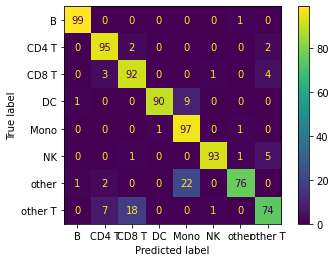

In [39]:
# confusion matrix for full matching
cm = confusion_matrix(labels_l1[full_matching[0]], labels_l1[full_matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100), 
    display_labels=np.unique(labels_l1)
).plot()